In [61]:
# Import Statements
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, Qobj, mesolve, expect
from quantum_logical.operators import selective_destroy

In [62]:
# Adjustable Parameters
coeff_args = {"k_a": 5, "t0_a": 7, "k_b": 5, "t0_b": 5}
tlist = np.linspace(0, 10, 100)

In [63]:
# Function Definitions
def logistic_function(t, k, t0):
    return 1 / (1 + np.exp(-k * (t - t0)))


def Ha_coeff(t, args):
    return (1 - logistic_function(t, args["k_a"], args["t0_a"])) * np.pi / 2


def Hb_coeff(t, args):
    return logistic_function(t, args["k_b"], args["t0_b"]) * np.pi / 2


def Ha_coeff_non_adiabatic(t, args):
    return 1 * np.pi / 2 if t < args.get("t_switch", 5) else 0


def Hb_coeff_non_adiabatic(t, args):
    return 1 * np.pi / 2 if t >= args.get("t_switch", 5) else 0


def time_dependent_H(t, adiabatic=True):
    if adiabatic:
        return Ha * Ha_coeff(t, coeff_args) + Hb * Hb_coeff(t, coeff_args)
    else:
        return Ha * Ha_coeff_non_adiabatic(t, coeff_args) + Hb * Hb_coeff_non_adiabatic(
            t, coeff_args
        )

In [64]:
# Hamiltonian Initialization
Ha = selective_destroy(3, 1, 0) + selective_destroy(3, 1, 0).dag()
Hb = selective_destroy(3, 2, 1) + selective_destroy(3, 2, 1).dag()
H = [[Ha, Ha_coeff], [Hb, Hb_coeff]]
rho0 = basis(3, 0) + basis(3, 2)
rho0 = rho0 / rho0.norm()
rho0 = rho0 * rho0.dag()

In [65]:
# Plotting Functions
def plot_drive_amplitudes():
    plt.figure(figsize=(8, 4))
    plt.plot(tlist, [Ha_coeff(t, coeff_args) for t in tlist], label="Ha Amplitude")
    plt.plot(tlist, [Hb_coeff(t, coeff_args) for t in tlist], label="Hb Amplitude")
    plt.xlabel("Time")
    plt.ylabel("Drive Amplitude")
    plt.title("Drive Amplitudes Over Time")
    plt.legend()
    plt.show()


def plot_eigenvalues(eigenvalues_adiabatic, eigenvalues_non_adiabatic):
    plt.figure(figsize=(8, 4))
    for i in range(eigenvalues_adiabatic.shape[1]):
        plt.plot(
            tlist, eigenvalues_adiabatic[:, i], label=f"Adiabatic Eigenvalue {i+1}"
        )
        plt.plot(
            tlist,
            eigenvalues_non_adiabatic[:, i],
            "--",
            label=f"Non-Adiabatic Eigenvalue {i+1}",
        )
    plt.xlabel("Time")
    plt.ylabel("Eigenvalues")
    plt.title("Eigenvalues of the Hamiltonian: Adiabatic vs Non-Adiabatic")
    plt.legend(ncols=2, bbox_to_anchor=(1, 1))
    plt.show()


def plot_expected_occupancy(output):
    e_state_projector = basis(3, 1) * basis(3, 1).dag()
    expected_occupancies = [expect(e_state_projector, state) for state in output.states]
    plt.plot(output.times, expected_occupancies)
    plt.xlabel("Time")
    plt.ylabel("Expected Occupancy of |e>")
    plt.title("Expected Occupancy of |e> State Over Time")
    plt.show()

In [66]:
# Compute Eigenvalues for Both Scenarios
eigenvalues_adiabatic = np.array(
    [Qobj(time_dependent_H(t)).eigenenergies() for t in tlist]
)
eigenvalues_non_adiabatic = np.array(
    [Qobj(time_dependent_H(t, adiabatic=False)).eigenenergies() for t in tlist]
)

In [67]:
# Solving the time-dependent Schrödinger equation
output = mesolve(H, rho0, tlist, args=coeff_args)

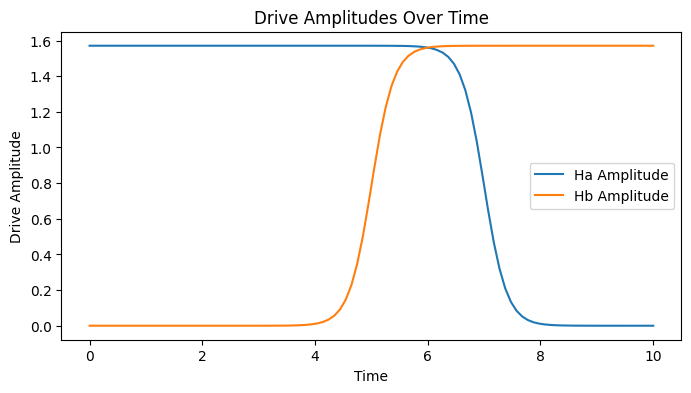

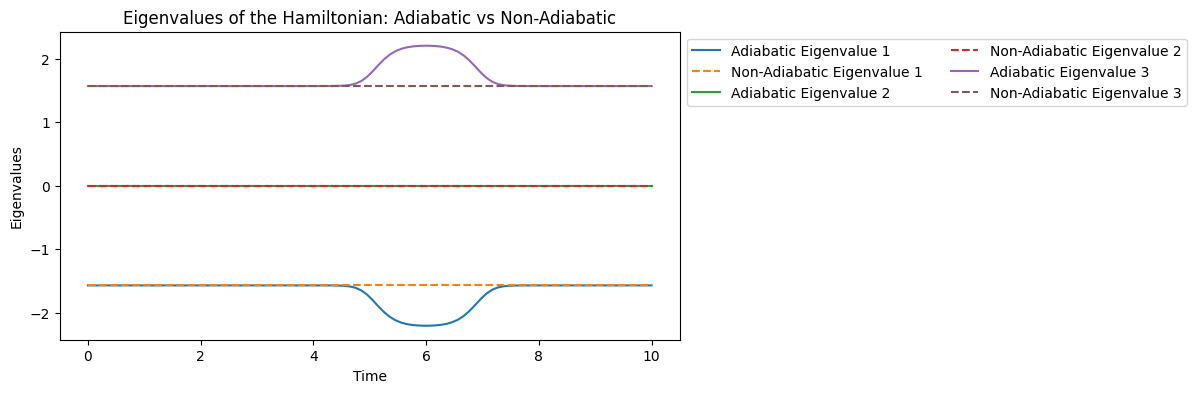

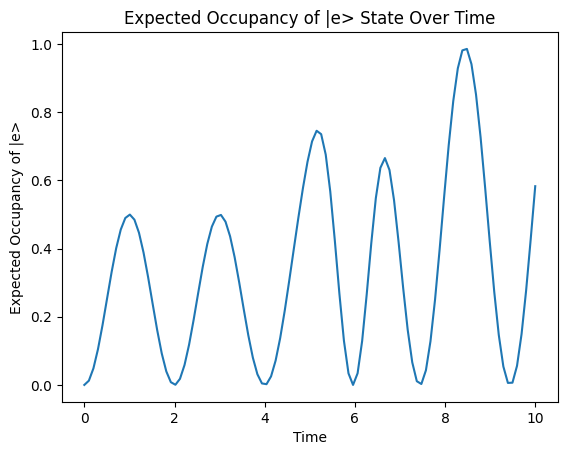

In [68]:
# Plotting
plot_drive_amplitudes()
plot_eigenvalues(eigenvalues_adiabatic, eigenvalues_non_adiabatic)
plot_expected_occupancy(output)